# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [1]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [2]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [4]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [5]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [6]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [7]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [8]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

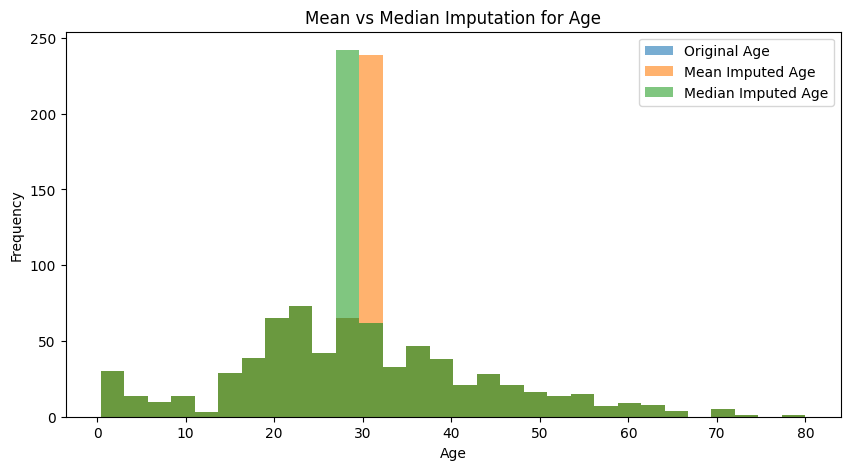

In [9]:
df_mean = df.copy()
df_median = df.copy()

df_mean['Age'] = df_mean['Age'].fillna(df_mean['Age'].mean())
df_median['Age'] = df_median['Age'].fillna(df_median['Age'].median())

plt.figure(figsize=(10,5))
plt.hist(df['Age'].dropna(), bins=30, alpha=0.6, label='Original Age')
plt.hist(df_mean['Age'], bins=30, alpha=0.6, label='Mean Imputed Age')
plt.hist(df_median['Age'], bins=30, alpha=0.6, label='Median Imputed Age')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Mean vs Median Imputation for Age")
plt.show()

In [10]:
df_mode = df.copy()
df_mode['Embarked'] = df_mode['Embarked'].fillna(df_mode['Embarked'].mode()[0])

df_unknown = df.copy()
df_unknown['Embarked'] = df_unknown['Embarked'].fillna('Unknown')

print("Original Embarked counts:\n", df['Embarked'].value_counts(dropna=False), "\n")
print("Mode Imputation counts:\n", df_mode['Embarked'].value_counts(), "\n")
print("Unknown Category counts:\n", df_unknown['Embarked'].value_counts(), "\n")

Original Embarked counts:
 Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64 

Mode Imputation counts:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64 

Unknown Category counts:
 Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64 



## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

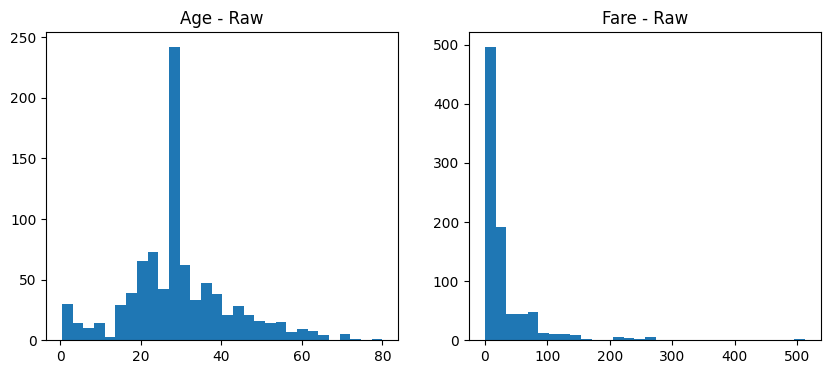

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

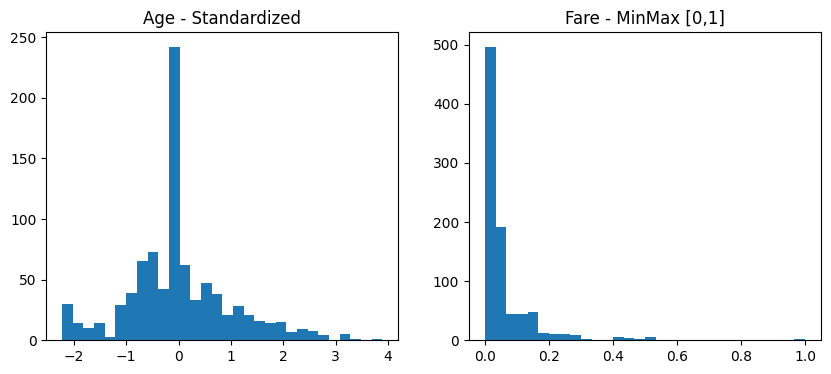

In [12]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

Text(0.5, 1.0, 'fare - Standardized')

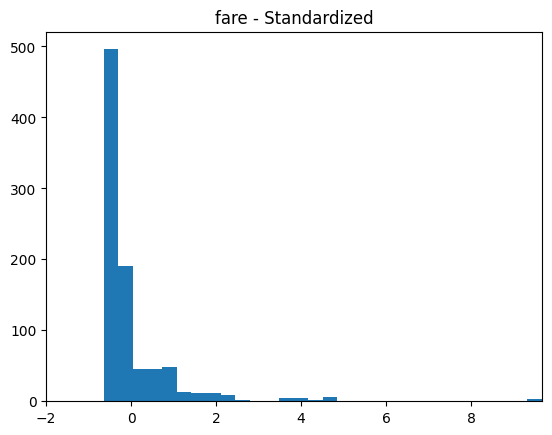

In [13]:
st=StandardScaler()
st_df= st.fit_transform(df_imp[['Fare']])
plt.hist(st_df.flatten(), bins=30)
plt.xlim(-2, st_df.max())
plt.title('fare - Standardized')

In [14]:
X = df_imp[['Age', 'Fare']]
norm = Normalizer()
X_norm = norm.fit_transform(X)
df_norm = pd.DataFrame(X_norm, columns=['Age_norm', 'Fare_norm'])
print(df_norm.head())

   Age_norm  Fare_norm
0  0.949757   0.312988
1  0.470417   0.882444
2  0.956551   0.291564
3  0.550338   0.834942
4  0.974555   0.224148


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [15]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [16]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [17]:
oe = OrdinalEncoder()
embarked_ordinal = oe.fit_transform(df_imp[['Embarked']])
print("Ordinal Encoded shape:", embarked_ordinal.shape)
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
print("One-Hot Encoded shape:", ohe_embarked.shape)

Ordinal Encoded shape: (891, 1)
One-Hot Encoded shape: (891, 3)


In [18]:
# it will not assume any order. Each category has its own coefficient, so the model can learn how each category affects the target separately.

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

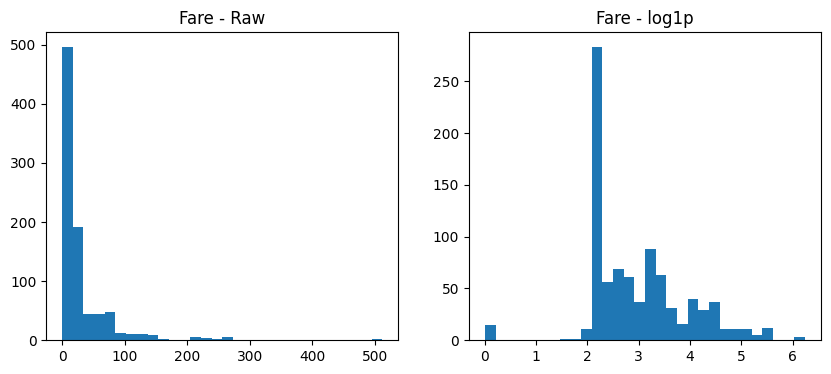

In [19]:
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

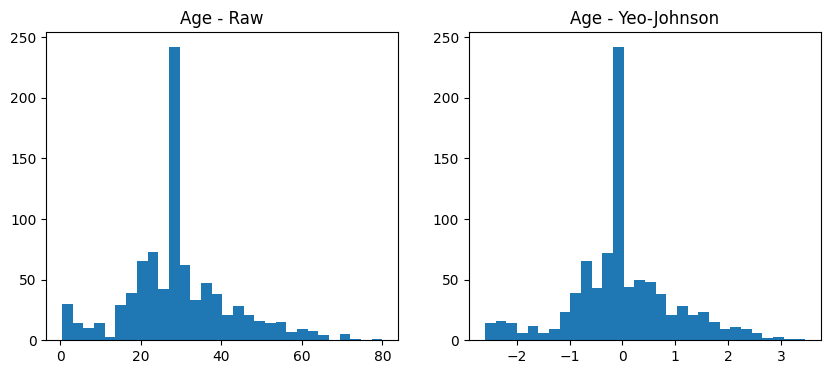

In [20]:
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [21]:
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Skewness of raw Fare: 4.787316519674893


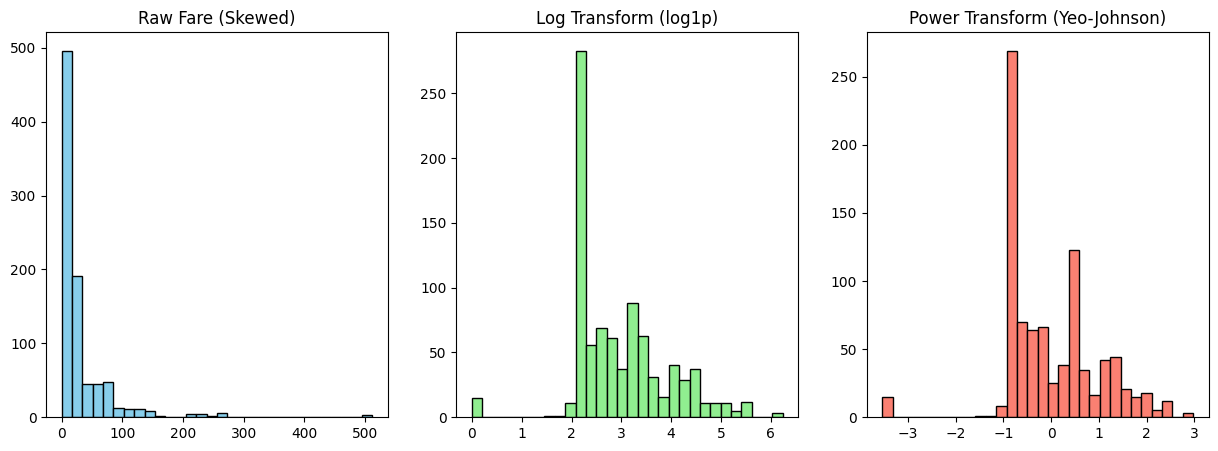

In [22]:
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
print("Skewness of raw Fare:", df_imp['Fare'].skew())
fare_log = np.log1p(fare_raw)
pt = PowerTransformer(method='yeo-johnson')
fare_power = pt.fit_transform(fare_raw)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(fare_raw, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Raw Fare (Skewed)")
axes[1].hist(fare_log, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title("Log Transform (log1p)")
axes[2].hist(fare_power, bins=30, color='salmon', edgecolor='black')
axes[2].set_title("Power Transform (Yeo-Johnson)")
plt.show()

In [42]:
X = df_imp[['Age', 'Fare']].dropna()
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(['Age','Fare'])
pd.DataFrame(X_poly, columns=feature_names).head()

,Age,Fare,Age^2,Age Fare,Fare^2
0,22.0,7.2500,484.0,159.5000,52.562500
1,38.0,71.2833,1444.0,2708.7654,5081.308859
2,26.0,7.9250,676.0,206.0500,62.805625
3,35.0,53.1000,1225.0,1858.5000,2819.610000
4,35.0,8.0500,1225.0,281.7500,64.802500


## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


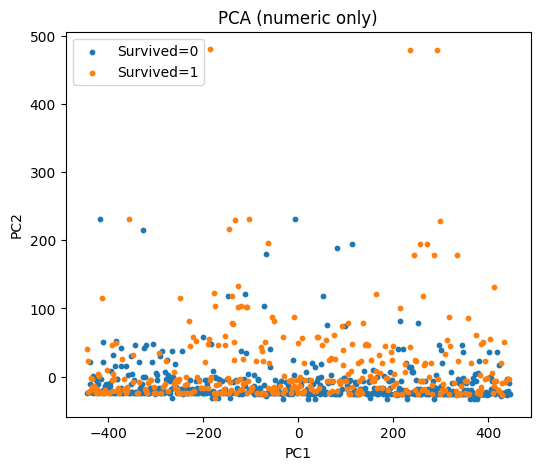

In [43]:
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)
print("Explained variance ratios:", pca.explained_variance_ratio_)
plt.figure(figsize=(6,5))
if y is not None:
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [25]:
numeric_vars = df_imp.var(numeric_only=True)
sorted_vars = numeric_vars.sort_values(ascending=False)
print("Variance of numeric columns:\n", sorted_vars, "\n")
top2 = sorted_vars.head(2)
print("The two numeric columns contributing the most variance before PCA are:\n", top2)

Variance of numeric columns:
 PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64 

The two numeric columns contributing the most variance before PCA are:
 PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [26]:
numeric_df = df_imp.select_dtypes(include=['number'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
pca = PCA(n_components=3)
pca.fit(scaled_data)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()
print("Explained variance ratio (per component):", explained_var)
print("Cumulative explained variance:", cumulative_var)

Explained variance ratio (per component): [0.26661069 0.23447227 0.14282597]
Cumulative explained variance: [0.26661069 0.50108296 0.64390893]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [27]:
df_clean = df.copy()
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())
df_clean['Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])
df_clean['Cabin'] = df_clean['Cabin'].fillna('Unknown')
print(df_clean.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [28]:
df_scaled = df_clean.copy()
scaler_age = StandardScaler()
df_scaled['Age_scaled'] = scaler_age.fit_transform(df_scaled[['Age']])
scaler_fare = MinMaxScaler()
df_scaled['Fare_scaled'] = scaler_fare.fit_transform(df_scaled[['Fare']])
print(df_scaled[['Age', 'Age_scaled', 'Fare', 'Fare_scaled']].head())

    Age  Age_scaled     Fare  Fare_scaled
0  22.0   -0.565736   7.2500     0.014151
1  38.0    0.663861  71.2833     0.139136
2  26.0   -0.258337   7.9250     0.015469
3  35.0    0.433312  53.1000     0.103644
4  35.0    0.433312   8.0500     0.015713


In [29]:
ohe_sex = pd.get_dummies(df_scaled['Sex'], prefix='Sex')
ohe_embarked = pd.get_dummies(df_scaled['Embarked'], prefix='Embarked')
df_encoded = pd.concat([df_scaled, ohe_sex, ohe_embarked], axis=1)
print(df_encoded.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare    Cabin Embarked  Age_scaled  \
0      0         A/5 21171   7.2500  Unknown        S   -0.565736   
1      0          PC 17599  71.2833      C85        C    0.663861   
2      0  STON/O2. 3101282   7.9250  Unknown        S   -0.258337   
3      0            113803  53.1000     C123

In [30]:
df_transformed = df_encoded.copy()
df_transformed['Fare_log'] = np.log1p(df_transformed['Fare'])
print(df_transformed[['Fare', 'Fare_log']].head())

      Fare  Fare_log
0   7.2500  2.110213
1  71.2833  4.280593
2   7.9250  2.188856
3  53.1000  3.990834
4   8.0500  2.202765


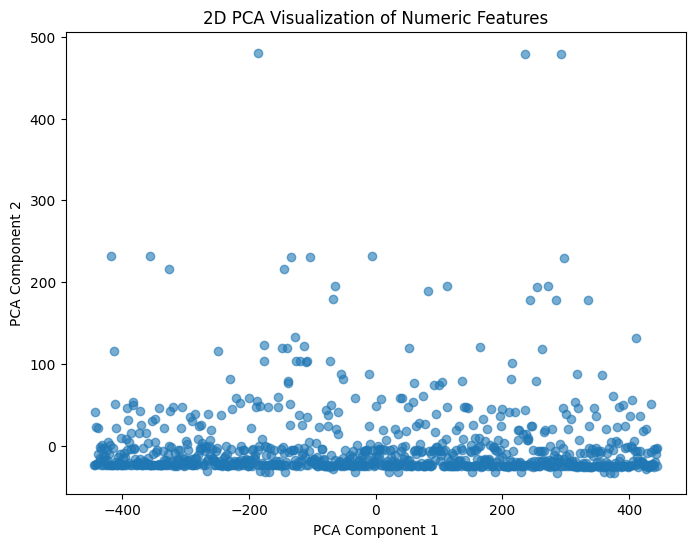

Explained variance ratio: [0.96162475 0.03588549]
Cumulative variance explained: 0.9975102385427032


In [31]:
numeric_cols = df_transformed.select_dtypes(include=['float64','int64']).columns
X_numeric = df_transformed[numeric_cols].dropna()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Visualization of Numeric Features")
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())

In [32]:
#Log transform (log1p) on Fare.
#Scaling (standardization, min-max) only rescaled values but didn’t change their shape.
# Imputation filled in missing values without altering the rest.
# Encoding added columns but didn’t touch numeric distributions.
# Log1p actually reshaped the skewed Fare distribution, pulling extreme values down and making it more symmetric.

In [ ]:
# One-hot encoding produced more features.
# Example: Embarked had 3 categories (C, Q, S).
# Ordinal encoding → 1 column (values like 0, 1, 2).
# One-hot encoding → 3 separate columns (Embarked_C, Embarked_Q, Embarked_S).
# Why? Because one-hot represents each category with a separate binary flag → more columns.
# This avoids introducing an artificial order (e.g., “C < Q < S”), which would mislead linear models.

In [41]:
df_encoded = pd.get_dummies(df_transformed, columns=['Sex', 'Embarked'], drop_first=True)
X = df_encoded.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
y = df_encoded['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7982062780269058


## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).